# Enron Fraud Project

Python 3.84

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from tester import dump_classifier_and_data
import tester

from time import time
import warnings
warnings.filterwarnings('ignore')

# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
enron_df = pd.DataFrame.from_dict(data_dict, orient = 'index')


In [2]:
# Set to True to run folds = 10,000 and 100,000 in additon to 1000
long_run_time = False

### Introduction
**Note to grader**: The tasks 1 through 6 are all identified in the h2 titles but follow the order taken in the project. The order is Task 2, 3, 1, 4, 5, 6. The correct order is given in the poi_id.py file but lacks the details. In addition, the questions are also answered in shortened form in the Question_answers.html file.

Summarize for us the **goal of this project** and **how machine learning is useful in trying to accomplish it**. 
As part of your answer, give some **background on the dataset** and **how it can be used to answer the project question**.

The goal of this project is to use Machine Learning algorithms from the sklearn library to detect persons of interest related to the Enron accounting fraud and eventual colapse of [Enron Corporation](https://en.wikipedia.org/wiki/Enron). 

Enron Corporation was founded in 1985 through a merger of two small regional energy companies and 15 years later, in 2000, would report a revenue of over 100 billion dollars. A little over a year later the company would file for bankruptcy. After an investigation, it was found that Enron along with partner companies, participated in schemes and even accounting fraud to hide losses.

The [Enron Fraud data set](https://github.com/trsvchn/ud120-projects-py3-jupyter) contains 20 features about email messages and financial information for 145 people and entities related to Enron. There is one additional "TOTAL" observation that will be removed. In addition to the 20 features, the data set includes a target variable that identifies persons of interest who were involved in the fraud. The data set is unbalanced with only 18 persons of interest out of the 145 obseravtions in the data set. 

After cleaning and data exploration, the 20 features will be reduced to the best features for finding persons involved in the fraud. These features will be analyzed using sklearn algorithms to find a model that best predicts persons of interest in the dataset. Finally, the best models will be tuned and evaluated using [recall and precision metrics](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/) to reduce the number of people falsely identified as persons of interest and increase the number of people correctly identified as persons involved.

## Task 0: Data Exploration

### Exploratory Data Analysis


In [3]:
enron_df.shape

(146, 21)

In [4]:
enron_df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN


The data set was initially a dictionary of dictionaries and was converted to a pandas dataframe for easier manipulation and reporting. The data contains 146 observations (rows) and 21 features (columns). The columns contain mixed data types and based on the first 5 rows seem to contain numerous missing values. Below is a list of the features.

In [5]:
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   salary                     146 non-null    object
 1   to_messages                146 non-null    object
 2   deferral_payments          146 non-null    object
 3   total_payments             146 non-null    object
 4   loan_advances              146 non-null    object
 5   bonus                      146 non-null    object
 6   email_address              146 non-null    object
 7   restricted_stock_deferred  146 non-null    object
 8   deferred_income            146 non-null    object
 9   total_stock_value          146 non-null    object
 10  expenses                   146 non-null    object
 11  from_poi_to_this_person    146 non-null    object
 12  exercised_stock_options    146 non-null    object
 13  from_messages              146 non-null    object

The above shows all rows except poi are mixed data or strings. It is noted that the poi feature is a pure data type (boolean) and contains no missing values. According to the information above, the other columns show no missing values but the initial 5 rows showed misssing values. This will need to be explored. The email column seems like it would provide no useful information in this analysis and will be removed.

In [6]:
# Above: Discuss shape "total number of data points".... mixed datatype objects but shows no Nulls. Investigate...
try:
    enron_df.drop(columns = ['email_address'], inplace = True)
except:
    pass
enron_df.describe().transpose().sort_values(by='freq', ascending=False)

,count,unique,top,freq
loan_advances,146,5,NaN,142
director_fees,146,18,NaN,129
restricted_stock_deferred,146,19,NaN,128
poi,146,2,False,128
deferral_payments,146,40,NaN,107
deferred_income,146,45,NaN,97
long_term_incentive,146,53,NaN,80
bonus,146,42,NaN,64
from_messages,146,65,NaN,60
shared_receipt_with_poi,146,84,NaN,60


Missing values are the most frequent values in every column except poi. Loan advances contain the least number of values though several other columns are missing significant values. These may be drop candidates if they do not contain useful persons of interest. Next, we will explore the issue of missing values not showing as nulls. 

In [7]:
# ** A lot of missing values but .info() shows none. Will investigate NaN values
# Did not pick up NaN. Investigate
print('Total Null values found:')
print(enron_df.isnull().sum(axis = 0))
# NaN is a string. Changing to np.nan
print('\n', 'NaN data type: ', type(enron_df.loc['METTS MARK','deferral_payments']))

Total Null values found:
salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
dtype: int64

 NaN data type:  <class 'str'>


The missing values (NaN) are string data types and not None datatypes. They will be converted to np.nan for analysis and reporting.

In [8]:
# NaNs are strings will convert to np.nans for EDA and revert back before final processing (testing.py)
enron_df.replace('NaN', np.nan, inplace = True)
print('Count of missing (null) values per feature\n')
print(enron_df.isnull().sum(axis = 0).sort_values(ascending=False))

Count of missing (null) values per feature

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_messages                 60
shared_receipt_with_poi       60
from_this_person_to_poi       60
from_poi_to_this_person       60
to_messages                   60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
total_payments                21
total_stock_value             20
poi                            0
dtype: int64


In [9]:
enron_df.describe()
# negative values

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,4.000000e+00,8.200000e+01,1.800000e+01,4.900000e+01,1.260000e+02,9.500000e+01,86.000000,1.020000e+02,86.000000,9.300000e+01,86.000000,6.600000e+01,86.000000,1.100000e+02,1.700000e+01
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,4.196250e+07,2.374235e+06,1.664106e+05,-1.140475e+06,6.773957e+06,1.087289e+05,64.895349,5.987054e+06,608.790698,9.190650e+05,41.232558,1.470361e+06,1176.465116,2.321741e+06,1.668049e+05
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,4.708321e+07,1.071333e+07,4.201494e+06,4.025406e+06,3.895777e+07,5.335348e+05,86.979244,3.106201e+07,1841.033949,4.589253e+06,100.073111,5.942759e+06,1178.317641,1.251828e+07,3.198914e+05
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,1.600000e+06,4.312500e+05,-3.896218e+05,-6.948620e+05,4.945102e+05,2.261400e+04,10.000000,5.278862e+05,22.750000,1.215000e+03,1.000000,2.812500e+05,249.750000,2.540180e+05,9.878400e+04
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,4.176250e+07,7.693750e+05,-1.469750e+05,-1.597920e+05,1.102872e+06,4.695000e+04,35.000000,1.310814e+06,41.000000,5.238200e+04,8.000000,4.420350e+05,740.500000,4.517400e+05,1.085790e+05
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,8.212500e+07,1.200000e+06,-7.500975e+04,-3.834600e+04,2.949847e+06,7.995250e+04,72.250000,2.547724e+06,145.500000,3.620960e+05,24.750000,9.386720e+05,1888.250000,1.002370e+06,1.137840e+05
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-8.330000e+02,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,609.000000,4.852193e+07,5521.000000,1.303223e+08,1.398517e+06


Nine columns show possible outliers with 2-fold magnitude differences between the top 75% and the maximum values. The deferred columns contain positive and negative values along with total stock value and restricted stock. 

In [10]:
# count negatives
sum(n < 0 for n in enron_df.values.flatten())

68

There are 68 negative values in the dataset. Negatives seem to have meaning, especially in the deferred columns and will not be changed to positive.

In [11]:
enron_df.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

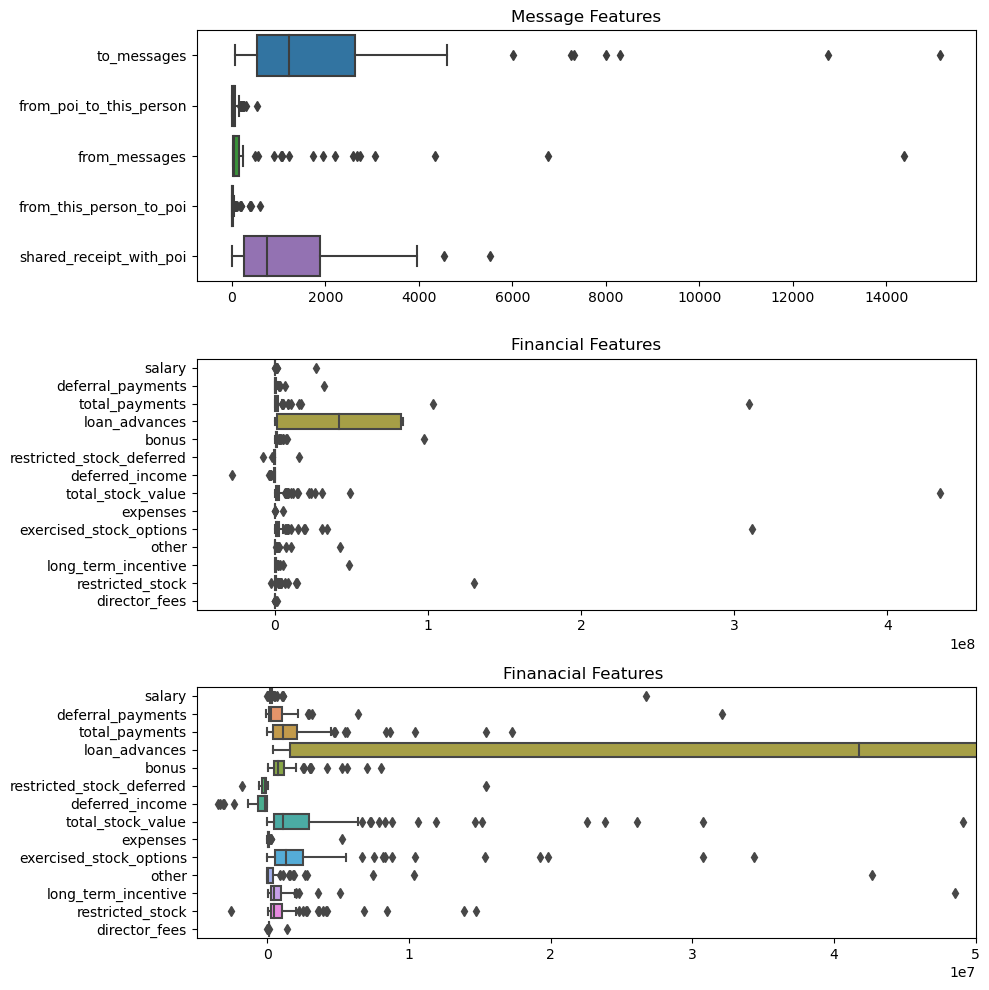

In [12]:
message_features_list = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
                        'from_this_person_to_poi', 'shared_receipt_with_poi']

financial_features_list = list(enron_df.drop(message_features_list, axis = 1).columns)
financial_features_list.remove('poi')

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(3, 1)

sns.boxplot(data = enron_df[message_features_list], orient = 'h', ax=ax[0])
sns.boxplot(data = enron_df[financial_features_list], orient = 'h', ax=ax[1])
sns.boxplot(data = enron_df[financial_features_list], orient = 'h', ax=ax[2])
ax[2].set_xlim([-5e6, 5*10**7])
ax[0].title.set_text('Message Features')
ax[1].title.set_text('Financial Features')
ax[2].title.set_text('Finanacial Features ')

There are many outliers in the data with the most signicant outliers being in the financial data. These will be investigated later in the analysis and either dropped or scaled depending on their relationships to persons of interest.

## Features Analysis

### Features missing value frequency
Next we will look for features with too few values as candidates for dropping. **Note**: Feature selection (Task 1) will occur later in the analysis after feature, observation and outlier removal.

,Missing_counts,Value_counts
poi,0,146
total_stock_value,20,126
total_payments,21,125
restricted_stock,36,110
exercised_stock_options,44,102
salary,51,95
expenses,51,95
other,53,93
from_poi_to_this_person,60,86
from_messages,60,86


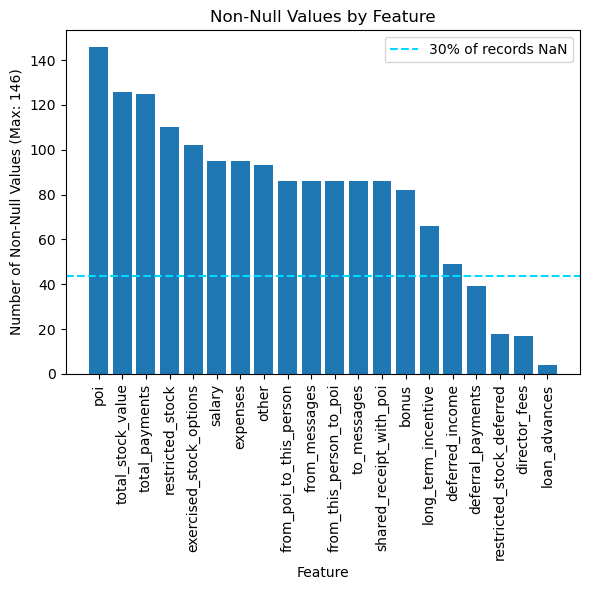

In [13]:
# Data Set feature null values analysis (column selection) for all observations

feature_value_counts = pd.DataFrame(enron_df.isnull().sum(axis = 0).sort_values(ascending = True), 
                                    columns = ['Missing_counts'])
feature_value_counts['Value_counts'] = 146 - feature_value_counts['Missing_counts']

plt.figure(figsize = (6, 6))
plt.bar(feature_value_counts.index, feature_value_counts['Value_counts'])
plt.axhline(0.3*len(enron_df.index), color = '#00daff', linestyle = '--')
plt.legend(['30% of records NaN'], loc='upper right')
plt.title('Non-Null Values by Feature')
plt.xlabel('Feature')
plt.ylabel('Number of Non-Null Values (Max: 146)')
plt.xticks(rotation=90);

feature_value_counts

Restricted sticted stocks, director fees and loan advances have less than 20 occurances in the data and will likely not be useful in the analiysis unless specific to persons of interest.

,Missing_counts,Value_counts
expenses,0,18
poi,0,18
other,0,18
total_payments,0,18
total_stock_value,0,18
restricted_stock,1,17
salary,1,17
bonus,2,16
from_poi_to_this_person,4,14
from_messages,4,14


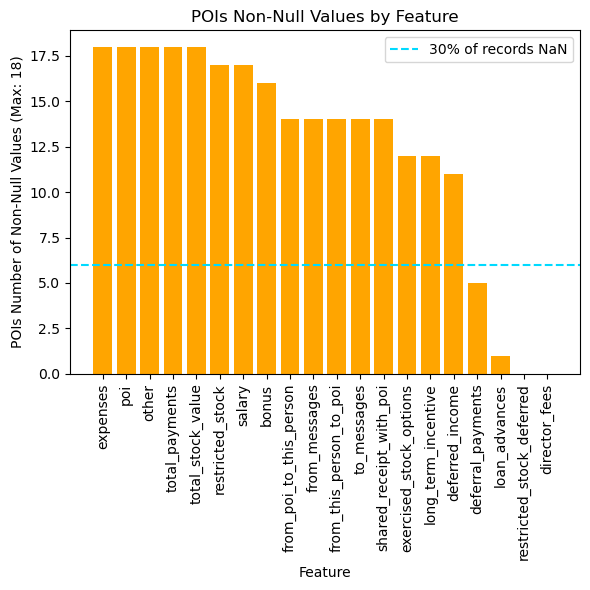

In [14]:
# Data Set feature null values analysis (column selection) for poi observations

poi_df = enron_df[enron_df['poi'] == True]
poi_nan_counts = pd.DataFrame(poi_df.isnull().sum().sort_values(ascending = True), 
                                    columns = ['Missing_counts'])

poi_nan_counts['Value_counts'] = 18 - poi_nan_counts['Missing_counts'] 

plt.figure(figsize = (6, 6))
plt.bar(poi_nan_counts.index, poi_nan_counts['Value_counts'], color ='#ffa500')
plt.axhline(0.3*len(poi_nan_counts.index), color='#00daff', linestyle = '--')
plt.legend(['30% of records NaN'], loc='upper right')
plt.title('POIs Non-Null Values by Feature')
plt.xlabel('Feature')
plt.ylabel('POIs Number of Non-Null Values (Max: 18)')
plt.xticks(rotation=90);

poi_nan_counts

Persons of interest have no occurances of restricted stock deferred and director fees features and only one occurance of loan advances. These three columns will be dropped. 

In [15]:
# From above: Low count on 'loan_advances', 'restricted_stock_deferred' and 'director_fees'; will remove column
try:
    enron_df.drop(columns = ['loan_advances', 'restricted_stock_deferred', 'director_fees'], inplace = True)
except:
    pass
print('The current dataframe has', enron_df.shape[0], 'rows and', enron_df.shape[1], 'columns')

The current dataframe has 146 rows and 17 columns


### Observation Data Features Count Analysis

In [16]:
# rows with few features row (observation) drop

nan_rows = pd.DataFrame(enron_df.isnull().sum(axis = 1), columns =['Missing_counts'])
nan_rows['Value_counts'] = len(enron_df.columns) - nan_rows['Missing_counts']
nan_rows.sort_values(by = 'Value_counts', inplace = True)
print('Records with missing features counts')
nan_rows.head(22)

Records with missing features counts


,Missing_counts,Value_counts
LOCKHART EUGENE E,16,1
GRAMM WENDY L,15,2
SCRIMSHAW MATTHEW,14,3
SAVAGE FRANK,14,3
WHALEY DAVID A,14,3
WODRASKA JOHN,14,3
CLINE KENNETH W,14,3
CHAN RONNIE,14,3
WROBEL BRUCE,14,3
WAKEHAM JOHN,14,3


Observations missing 13 or more features.


,Missing_counts,Value_counts
salary,21,0
to_messages,21,0
shared_receipt_with_poi,21,0
long_term_incentive,21,0
from_this_person_to_poi,21,0
from_messages,21,0
from_poi_to_this_person,21,0
bonus,21,0
deferral_payments,21,0
other,19,2


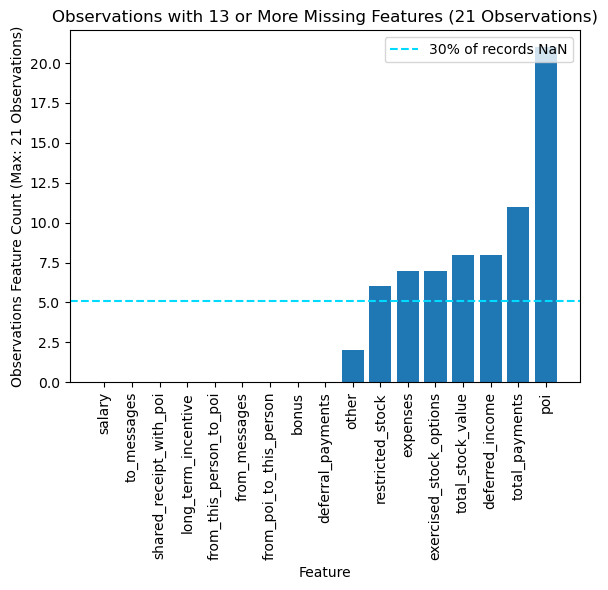

In [17]:
# records missing 13 or more features

low_feature_list = nan_rows.index[0:21]
low_feature_df = enron_df.loc[low_feature_list]

low_feature_nan_counts = pd.DataFrame(low_feature_df.isnull().sum().sort_values(ascending = False), 
                                    columns = ['Missing_counts'])
low_feature_nan_counts['Value_counts'] = len(low_feature_list) - low_feature_nan_counts['Missing_counts'] 

plt.figure(figsize = (6, 6))
plt.bar(low_feature_nan_counts.index, low_feature_nan_counts['Value_counts'])
plt.axhline(0.3*len(low_feature_nan_counts.index), color = '#00daff', linestyle = '--')
plt.legend(['30% of records NaN'], loc='upper right')
plt.title('Observations with 13 or More Missing Features (21 Observations)')
plt.xlabel('Feature')
plt.ylabel('Observations Feature Count (Max: 21 Observations)')
plt.xticks(rotation=90);

print('Observations missing 13 or more features.')
low_feature_nan_counts

In [18]:
# Are any of above persons of interest
poi_low_features = low_feature_df[low_feature_df['poi']]
print("There are", len(poi_low_features), 'persons of interest in the low feature data above.')

if (len(poi_low_features) != 0):
    display(poi_low_features)

There are 0 persons of interest in the low feature data above.


In [19]:
# dropping rows and verify shape

low_feature_df[low_feature_df['total_payments'].isna()]
drop_list = list(low_feature_df[low_feature_df['total_payments'].isna()].index)
drop_list.append('THE TRAVEL AGENCY IN THE PARK')

print('Dropping the following non-person of interest with 13 or more missing feature values:\n')
pprint(drop_list)

try:
    enron_df = enron_df.drop(index = drop_list)
    print('\n', len(drop_list), 'rows dropped. Shape is now:', enron_df.shape)
except:
    print('\n',len(drop_list), 'rows dropped. Shape is now:', enron_df.shape)

Dropping the following non-person of interest with 13 or more missing feature values:

['LOCKHART EUGENE E',
 'SCRIMSHAW MATTHEW',
 'WHALEY DAVID A',
 'CLINE KENNETH W',
 'CHAN RONNIE',
 'WROBEL BRUCE',
 'LOWRY CHARLES P',
 'CHRISTODOULOU DIOMEDES',
 'GATHMANN WILLIAM D',
 'GILLIS JOHN',
 'THE TRAVEL AGENCY IN THE PARK']

 11 rows dropped. Shape is now: (135, 17)


## Outlier Analysis and Removal (Task 2)

Were there any **outliers in the data** when you got it, and **how did you handle those**?  relevant rubric items: “data exploration”, “outlier investigation”

Next we will look at outliers that exist in the data as possible removal candidates.

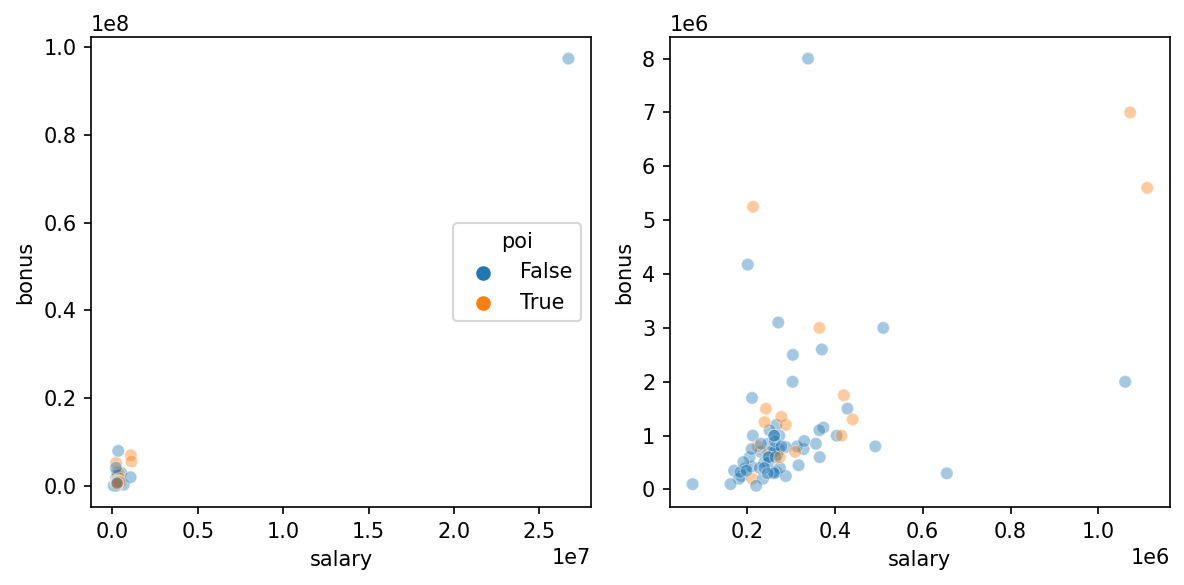

In [20]:
# explore salary bonus data for clusters and outliers

# plt.figure(figsize = (4, 3), dpi = 100)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams["legend.loc"] = 'center right'
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.scatterplot(data = enron_df, y = 'bonus', x = 'salary', hue = 'poi', alpha = 0.4, ax=axes[0]);
try:
    enron_df[enron_df['salary'] > 10**7]
    total_record = enron_df.loc['TOTAL']
    enron_df.drop(index = 'TOTAL', inplace = True);
except: pass

sns.scatterplot(data = enron_df, y = 'bonus', x = 'salary', hue = 'poi', legend=False, alpha = 0.4, ax=axes[1]);


In [21]:
enron_df[enron_df['bonus'] > 4*10**6]

,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
LAVORATO JOHN J,339288.0,7259.0,NaN,10425757.0,8000000.0,NaN,5167144.0,49537.0,528.0,4158995.0,2585.0,1552.0,411.0,False,2035380.0,3962.0,1008149.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,7000000.0,-300000.0,49110078.0,99832.0,123.0,34348384.0,36.0,10359729.0,16.0,True,3600000.0,2411.0,14761694.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,5249999.0,-2334434.0,1110705.0,17355.0,228.0,953136.0,484.0,210698.0,108.0,True,NaN,5521.0,157569.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,5600000.0,NaN,26093672.0,29336.0,88.0,19250000.0,108.0,22122.0,30.0,True,1920000.0,2042.0,6843672.0
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,4175000.0,-3081055.0,1729541.0,13868.0,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0


In [22]:
enron_df[enron_df['salary'] > 0.6*10**6]

,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,7000000.0,-300000.0,49110078.0,99832.0,123.0,34348384.0,36.0,10359729.0,16.0,True,3600000.0,2411.0,14761694.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,5600000.0,NaN,26093672.0,29336.0,88.0,19250000.0,108.0,22122.0,30.0,True,1920000.0,2042.0,6843672.0
PICKERING MARK R,655037.0,898.0,NaN,1386690.0,300000.0,NaN,28798.0,31653.0,7.0,28798.0,67.0,NaN,0.0,False,NaN,728.0,NaN
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,2000000.0,-3367011.0,14622185.0,86987.0,242.0,10433518.0,21.0,7427621.0,6.0,False,1617011.0,2979.0,4188667.0


The outlier shown in the left figure above was "TOTAL" and represents a columns total. The figure on the right shows the new scatterplot after removal of "TOTAL". There are still outliers in this data but the remaining outliers are valid data points that would exist in the real world data. In addition, many of the outliers are identified as persons of interest and removal of them would reduce the target label counts by 17% leaving only 15 persons of interest out of 134 observations. Therefore, they will be left in the data. Next we will look at other features scatterplots and outliers.

<Figure size 800x400 with 0 Axes>

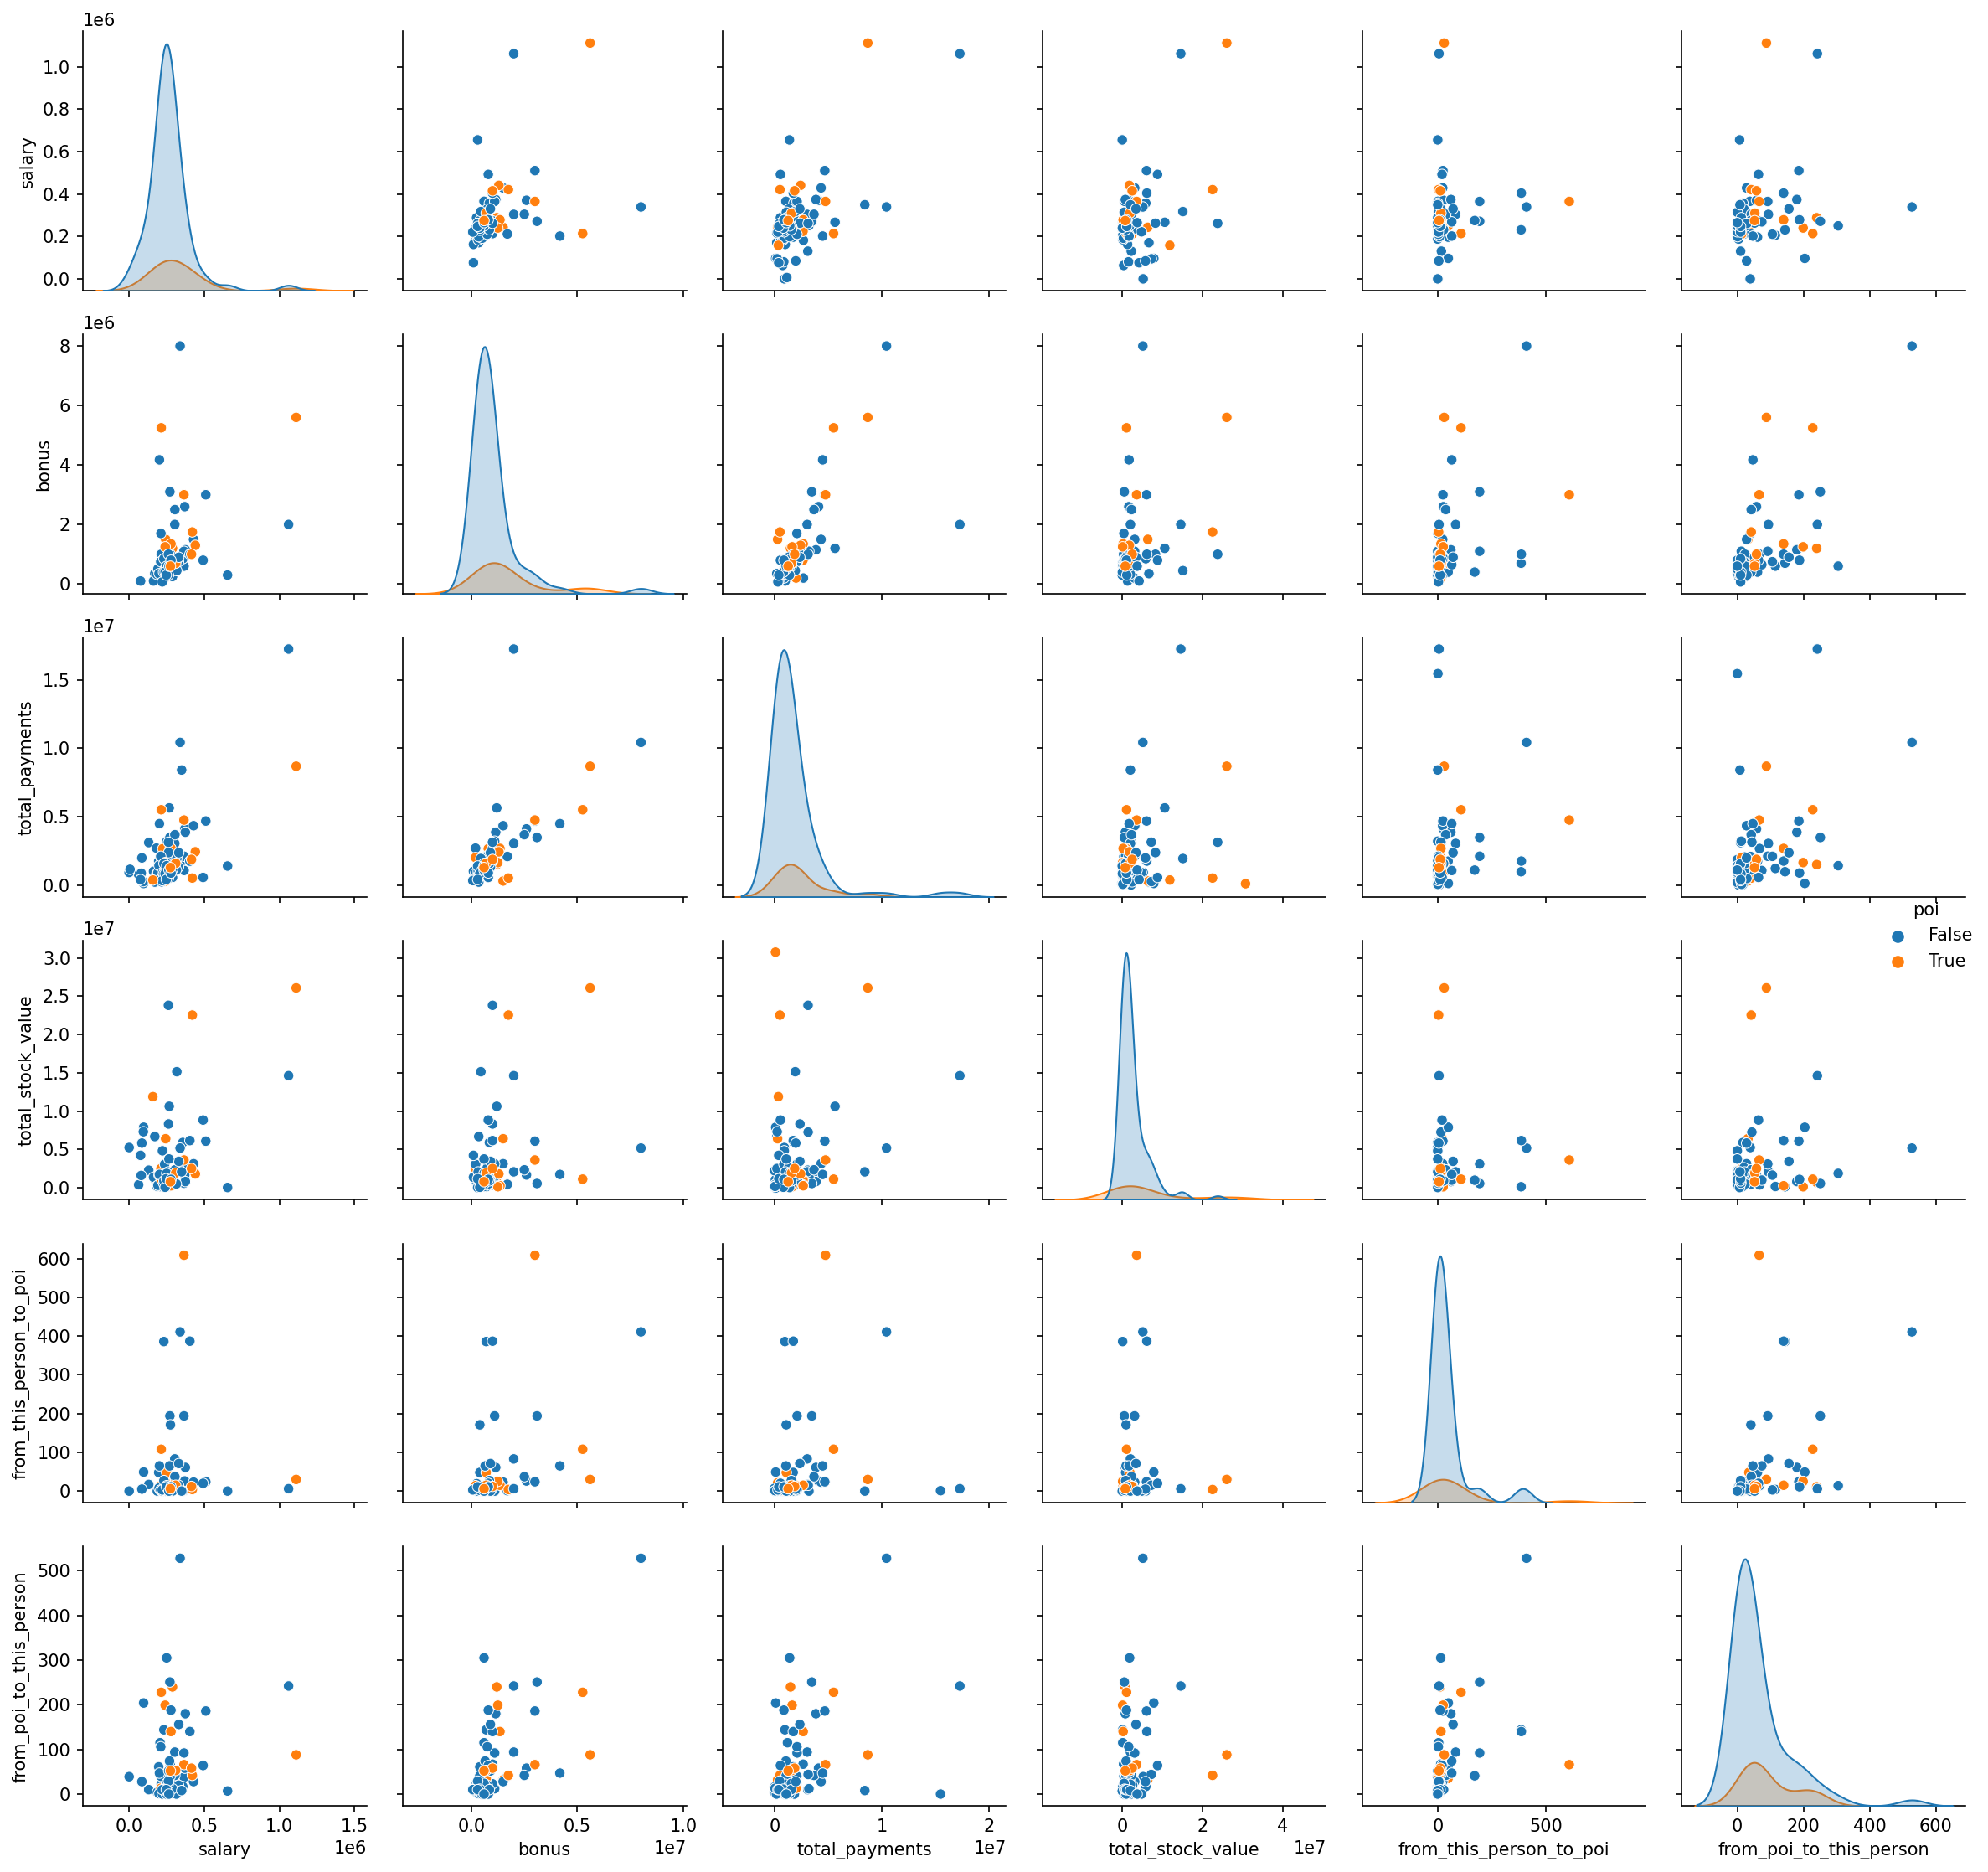

In [23]:
# look for other outliers
corr_feature_list = ['poi', 'salary', 'bonus', 'total_payments', 'total_stock_value', 
                     'from_this_person_to_poi', 'from_poi_to_this_person']

plt.figure(figsize = (8, 4), dpi = 100)
sns.pairplot(enron_df[enron_df['total_payments'] < 100000000][corr_feature_list], hue = 'poi');

In [24]:
# Other possible outliers
print("Total payments over $9 million.")
enron_df[enron_df['total_payments'] > 9000000]

Total payments over $9 million.


,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
LAVORATO JOHN J,339288.0,7259.0,NaN,10425757.0,8000000.0,NaN,5167144.0,49537.0,528.0,4158995.0,2585.0,1552.0,411.0,False,2035380.0,3962.0,1008149.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,7000000.0,-300000.0,49110078.0,99832.0,123.0,34348384.0,36.0,10359729.0,16.0,True,3600000.0,2411.0,14761694.0
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,NaN,NaN,NaN,NaN,0.0,2604490.0,29.0,137864.0,1.0,False,NaN,463.0,-2604490.0
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,2000000.0,-3367011.0,14622185.0,86987.0,242.0,10433518.0,21.0,7427621.0,6.0,False,1617011.0,2979.0,4188667.0


In [25]:
print("From poi to this person messages over 400.")
enron_df[enron_df['from_poi_to_this_person'] > 400]

From poi to this person messages over 400.


,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
LAVORATO JOHN J,339288.0,7259.0,NaN,10425757.0,8000000.0,NaN,5167144.0,49537.0,528.0,4158995.0,2585.0,1552.0,411.0,False,2035380.0,3962.0,1008149.0


In [26]:
print("From this person to poi messages over 300.")
enron_df[enron_df['from_this_person_to_poi'] > 300]

From this person to poi messages over 300.


,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
BECK SALLY W,231330.0,7315.0,NaN,969068.0,700000.0,NaN,126027.0,37172.0,144.0,NaN,4343.0,566.0,386.0,False,NaN,2639.0,126027.0
LAVORATO JOHN J,339288.0,7259.0,NaN,10425757.0,8000000.0,NaN,5167144.0,49537.0,528.0,4158995.0,2585.0,1552.0,411.0,False,2035380.0,3962.0,1008149.0
DELAINEY DAVID W,365163.0,3093.0,NaN,4747979.0,3000000.0,NaN,3614261.0,86174.0,66.0,2291113.0,3069.0,1661.0,609.0,True,1294981.0,2097.0,1323148.0
KEAN STEVEN J,404338.0,12754.0,NaN,1747522.0,1000000.0,NaN,6153642.0,41953.0,140.0,2022048.0,6759.0,1231.0,387.0,False,300000.0,3639.0,4131594.0


In [27]:
print("Total stock value over $20 million.")
enron_df[enron_df['total_stock_value'] > 20000000]

Total stock value over $20 million.


,salary,to_messages,deferral_payments,total_payments,bonus,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,7000000.0,-300000.0,49110078.0,99832.0,123.0,34348384.0,36.0,10359729.0,16.0,True,3600000.0,2411.0,14761694.0
RICE KENNETH D,420636.0,905.0,NaN,505050.0,1750000.0,-3504386.0,22542539.0,46950.0,42.0,19794175.0,18.0,174839.0,4.0,True,1617011.0,864.0,2748364.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,5600000.0,NaN,26093672.0,29336.0,88.0,19250000.0,108.0,22122.0,30.0,True,1920000.0,2042.0,6843672.0
HIRKO JOSEPH,NaN,NaN,10259.0,91093.0,NaN,NaN,30766064.0,77978.0,NaN,30766064.0,NaN,2856.0,NaN,True,NaN,NaN,NaN
PAI LOU L,261879.0,NaN,NaN,3123383.0,1000000.0,NaN,23817930.0,32047.0,NaN,15364167.0,NaN,1829457.0,NaN,False,NaN,NaN,8453763.0


Of the 11 outliers above, 5 are persons of interest and represent 28% of our target variable. Removing these observations would make the data even more unbalanced. The remaining 6 have reasonable values that would be seen in other real world data. Therefore, these outliers will not be removed. Next, I will examine the correlation matrix for the features with a focus finding feature engineering candidates.

## Feature Engineering: Create new feature (Task 3)

Correlation Matrix for all observations


<AxesSubplot:>

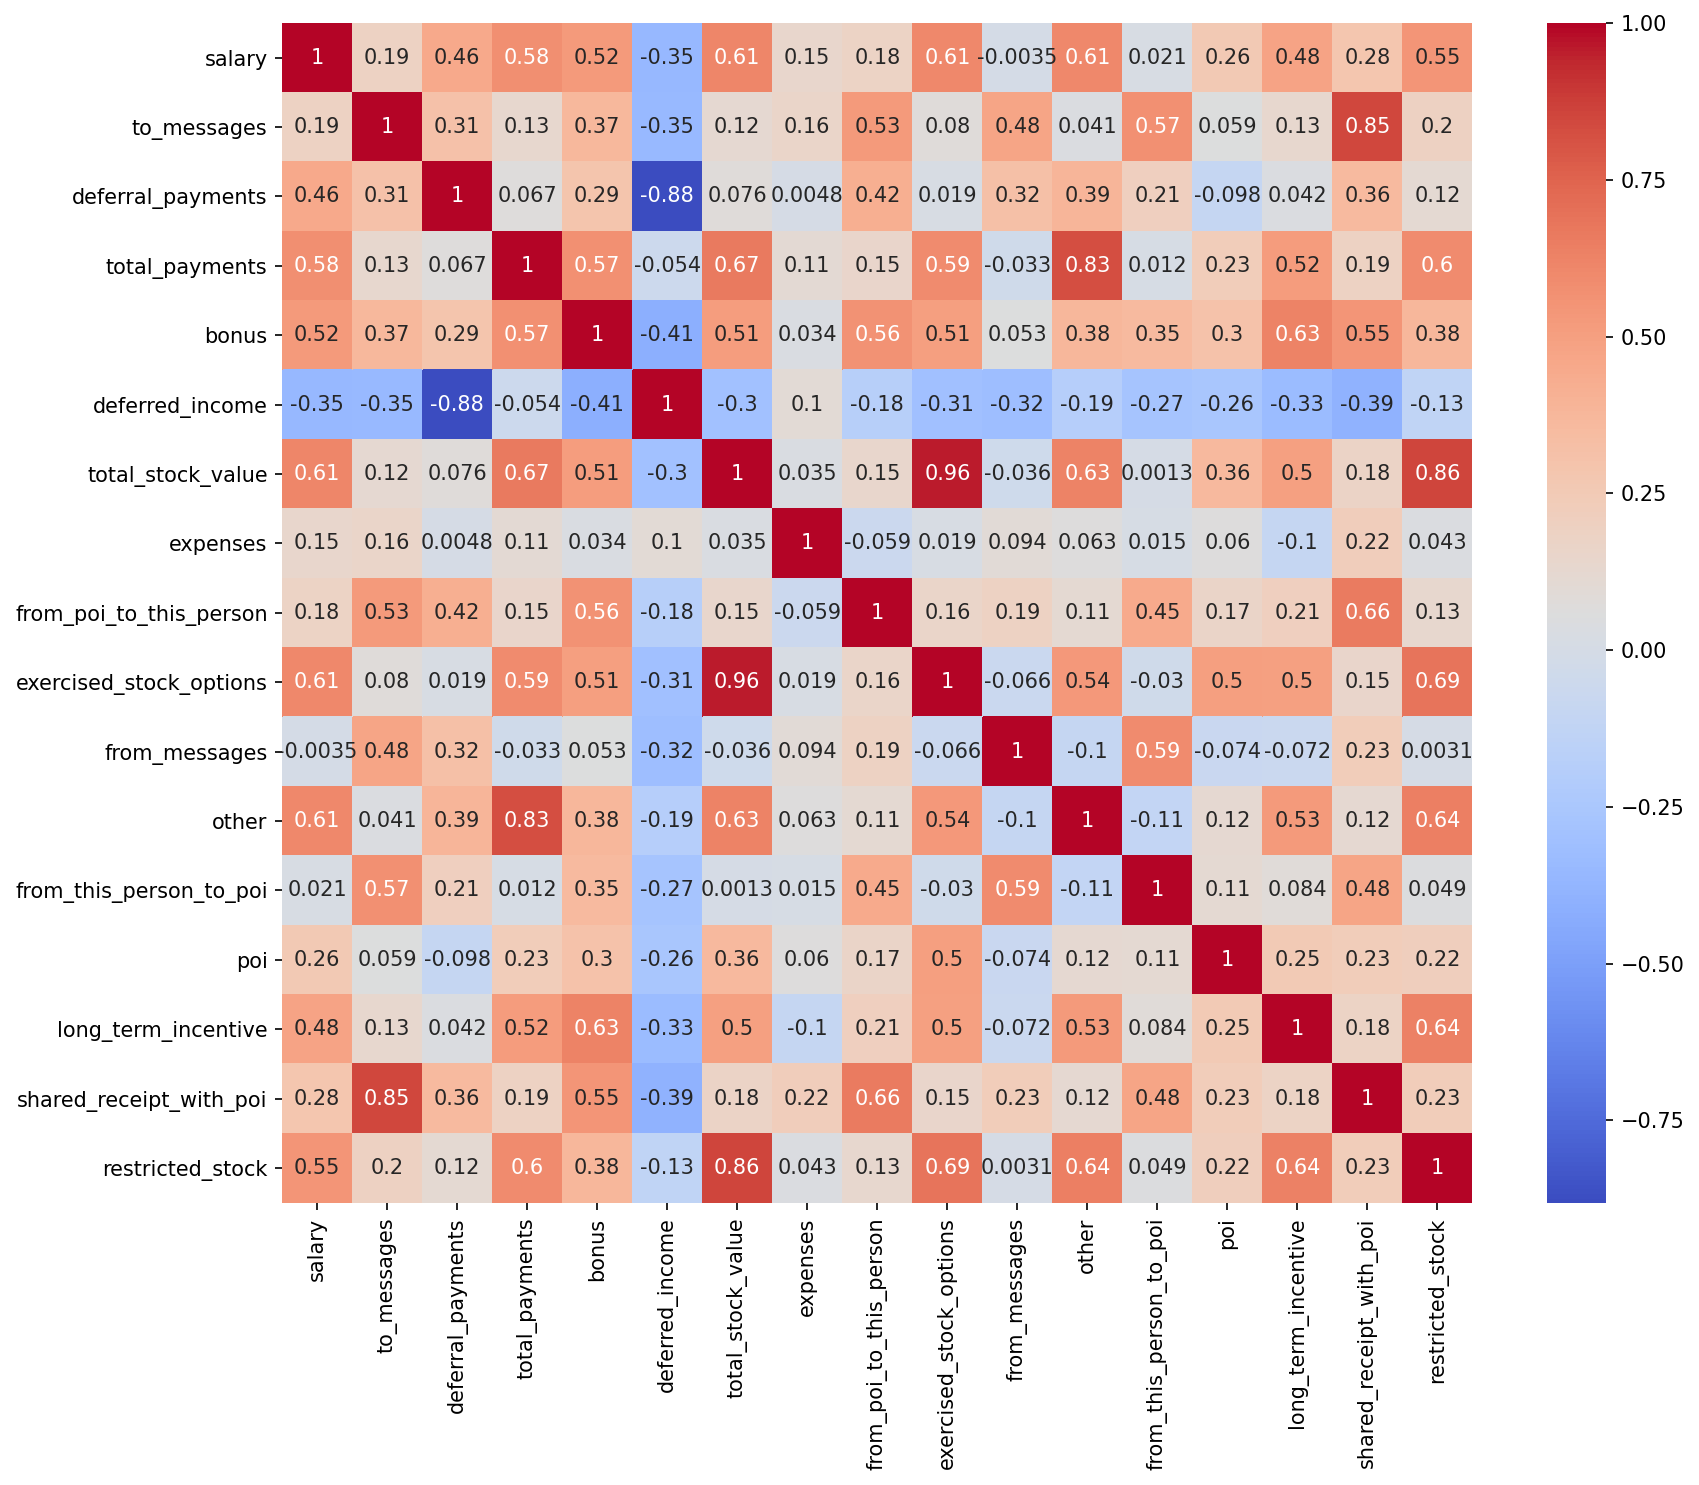

In [28]:
# correlation plot for feature engineering and selection
plt.figure(figsize = (12, 10), dpi=150)
print('Correlation Matrix for all observations')
sns.heatmap(enron_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

Correlation Matrix for persons of interest only (poi removed)


<AxesSubplot:>

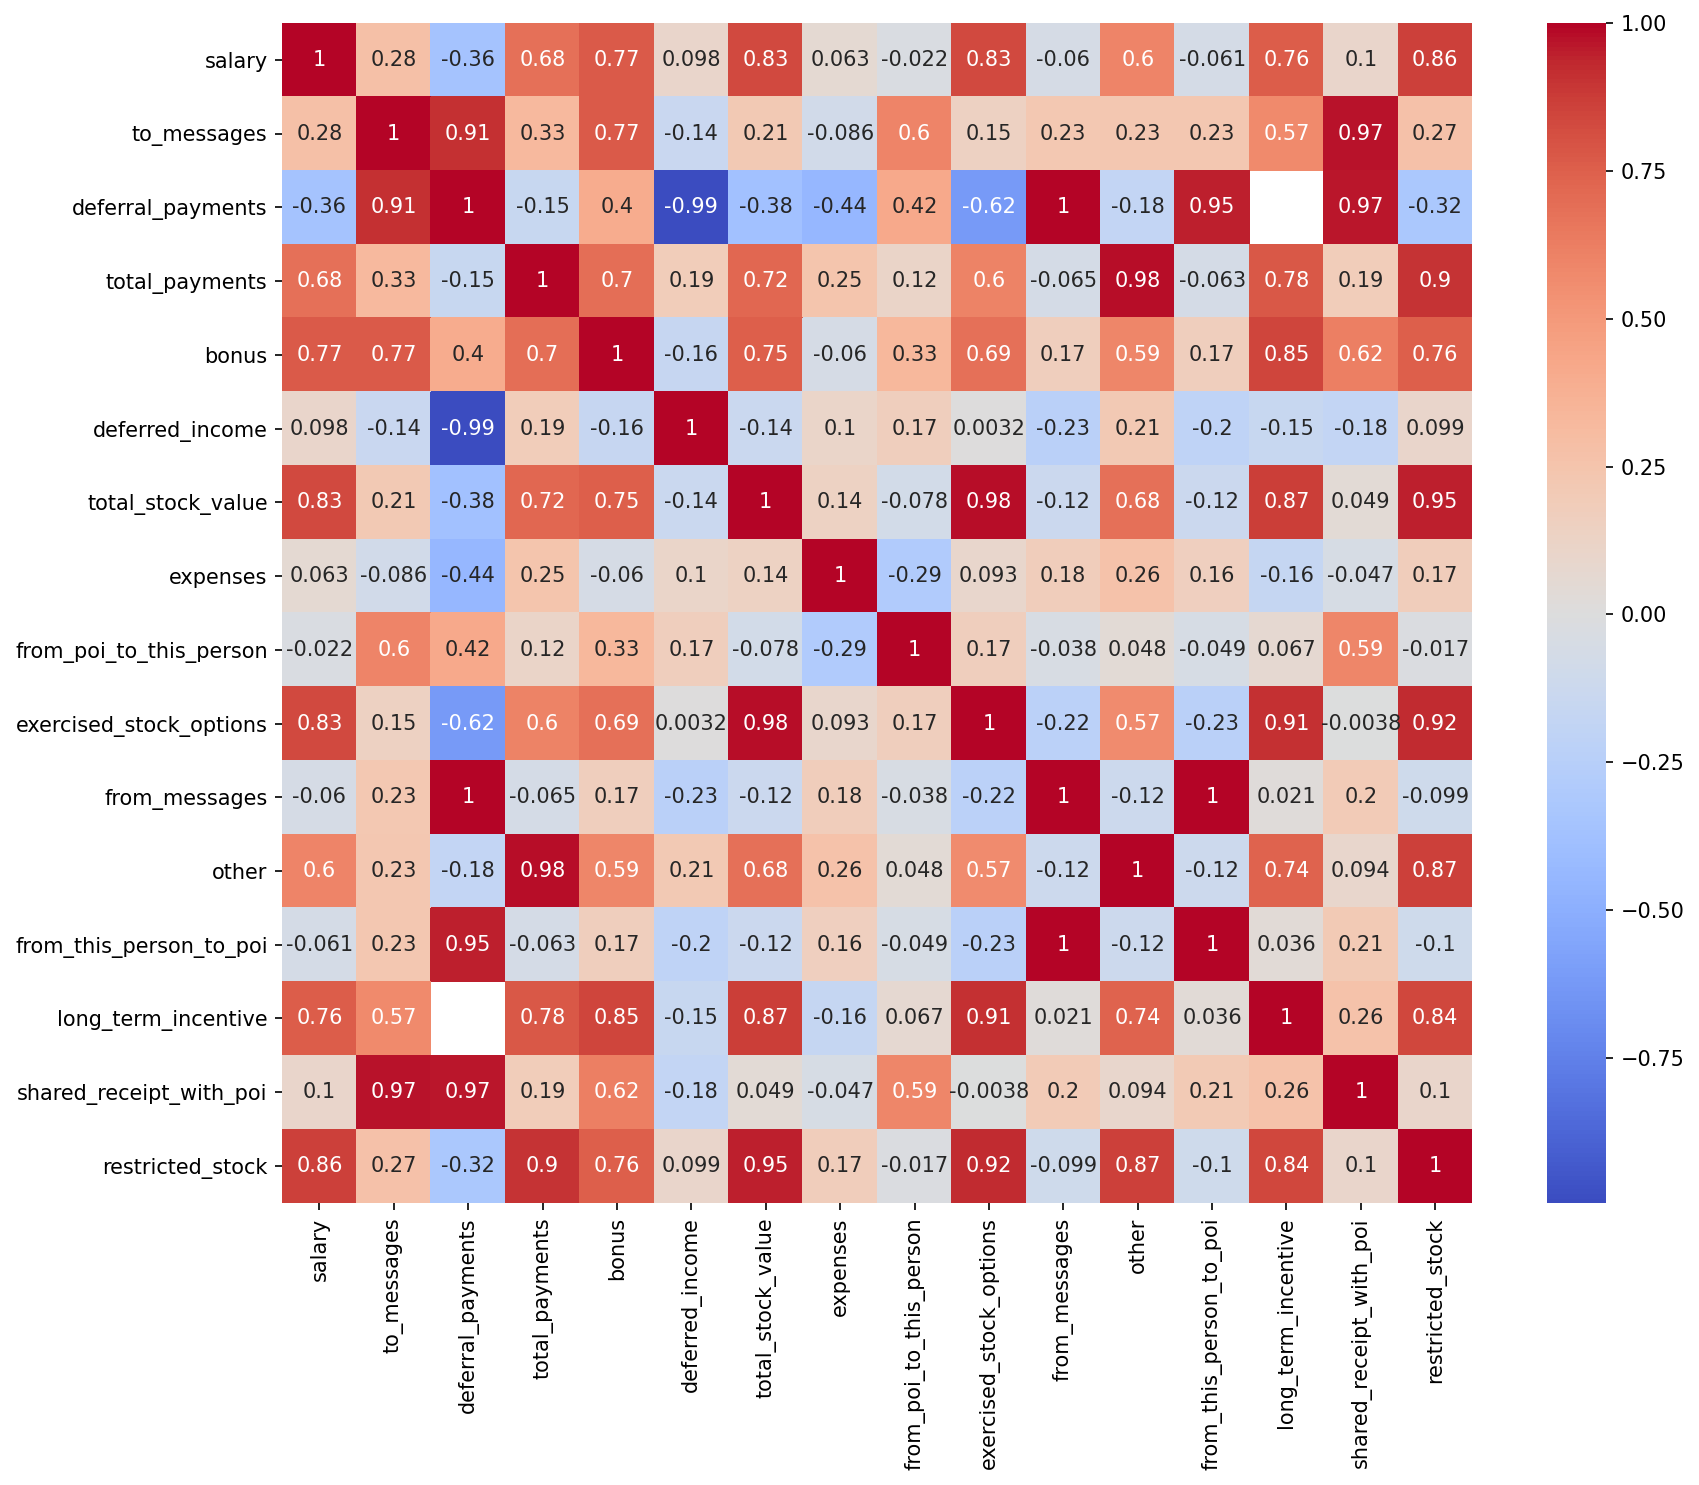

In [29]:
# poi correlation plot for feature engineering and selection
plt.figure(figsize = (12, 10), dpi=150)
poi_df = enron_df[enron_df['poi'] == True]
print('Correlation Matrix for persons of interest only (poi removed)')
sns.heatmap(poi_df.drop('poi', axis=1).corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

The to messages and from messages on their own seem like they would provide no relevant information and might provide false information about poi relationships. Therefore, these two columns will be combined with other columns and then dropped. A from this person to poi to from messages ratio will be used to eliminate the from messages feature. This ratio shows a perfect correlation in the poi correlation matrix and a moderate correlation with all data. A shared receipt with poi to to_messages ratio will be used to remove the to_messages column. The correlation is strong in both correlation matrices but is higher in the poi matrix.

Other new features added are based on intuition, in that higher values seem like they would identify persons of interest are:
- The ratio of the bonus to total payments. The reasoning is a higher bonus may be given as a reward for towing the company line.
- The total payments minus the salary. The reasoning is the same as above. Salaries are mostly fixed and consistent. All other payments may be rewards for towing the line.
- The ratio of excercised stock options to total stock value. More stock options with shorter excercise periods may be a reward for ignoring irregularities and towing the company line.

The data set with the dropped to and from messages, and added features now has 20 columns and 134 rows.

In [30]:
# add new features

try:
    enron_df['bonus_totalpay_ratio'] = enron_df['bonus'].divide(enron_df['total_payments'], fill_value = 0.0 )
    enron_df['total_minus_sal'] = enron_df['total_payments'].sub(enron_df['salary'], fill_value = 0.0 )
    enron_df['exec_stock_tot_ratio'] = enron_df['exercised_stock_options'].divide(enron_df['total_stock_value'], fill_value = 0.0 )
    enron_df['from_poi_total_from_ratio'] = enron_df['from_this_person_to_poi'].divide(enron_df['from_messages'], fill_value = 0.0)
    enron_df['shared_rec_to_mes_ratio'] = enron_df['shared_receipt_with_poi'].divide(enron_df['to_messages'], fill_value = 0.0)
    enron_df.drop(['to_messages', 'from_messages'], axis = 1, inplace=True)
except:
    pass

# Change inf to zero if found
enron_df.replace([np.inf, -np.inf], np.nan, inplace=True)
enron_df.shape

(134, 20)

The next table compares the correlation of the features to poi (bool).

In [31]:
# What are the correlations of the other columns
corr = enron_df.corr()
corr[['poi']].sort_values(by = 'poi', ascending = False)

,poi
poi,1.000000
exercised_stock_options,0.500832
total_stock_value,0.361664
from_poi_total_from_ratio,0.339938
bonus_totalpay_ratio,0.334939
bonus,0.302384
shared_rec_to_mes_ratio,0.265225
salary,0.264976
long_term_incentive,0.254723
total_payments,0.230102


In [32]:
# Change np.nan back to str 'NaN' and send back to dict of dicts
# for use of tools provided (featureFormat.py, testing.py)

enron_df.fillna("NaN", inplace = True)
my_dataset = enron_df.to_dict(orient = 'index')

The np.nan data types were converted back to string 'NaN' and the data was converted back to a dictionary of dictionaries so that the supplied helper files featureFormay.py and testing.py may be utilized. The following shows the dictionary of dictionaries format.

In [33]:
# Verify dict structure is created as intended
test = list(my_dataset.items())[0]
pprint(test)

('METTS MARK',
 {'bonus': 600000.0,
  'bonus_totalpay_ratio': 0.5650638004119315,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'exec_stock_tot_ratio': 0.0,
  'exercised_stock_options': 'NaN',
  'expenses': 94299.0,
  'from_poi_to_this_person': 38.0,
  'from_poi_total_from_ratio': 0.034482758620689655,
  'from_this_person_to_poi': 1.0,
  'long_term_incentive': 'NaN',
  'other': 1740.0,
  'poi': False,
  'restricted_stock': 585062.0,
  'salary': 365788.0,
  'shared_rec_to_mes_ratio': 0.8698884758364313,
  'shared_receipt_with_poi': 702.0,
  'total_minus_sal': 696039.0,
  'total_payments': 1061827.0,
  'total_stock_value': 585062.0})


In [34]:
print('There are', len(my_dataset.keys()), 'records and', len(my_dataset[list(my_dataset.keys())[0]]), 'rows in my_dataset')
# print(my_dataset)

There are 134 records and 20 rows in my_dataset


In [35]:
# Create features list from current df/dict features
# 'poi' must be first item in list
features_list = ['poi']
columns_list = list(enron_df.columns)
columns_list = [feature for feature in columns_list if feature not in ('poi')]
features_list.extend(columns_list)

# features_list = get_features(enron_df, exclude_cols = ('email_address'))

print("The current features and target are:")
pprint(features_list)

The current features and target are:
['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'bonus_totalpay_ratio',
 'total_minus_sal',
 'exec_stock_tot_ratio',
 'from_poi_total_from_ratio',
 'shared_rec_to_mes_ratio']


## Feature Selection (Task 1)

                              scores
exercised_stock_options    22.910167
total_stock_value          22.145452
bonus                      18.389429
bonus_totalpay_ratio       18.264169
salary                     15.719216
from_poi_total_from_ratio  14.330200
deferred_income            10.260428
long_term_incentive         8.578790
restricted_stock            8.194874
total_payments              7.865810
total_minus_sal             7.552610
shared_rec_to_mes_ratio     7.360386
shared_receipt_with_poi     7.189529
expenses                    4.853689
from_poi_to_this_person     4.342734
other                       3.662856
from_this_person_to_poi     1.993338
deferral_payments           0.302468
exec_stock_tot_ratio        0.008577


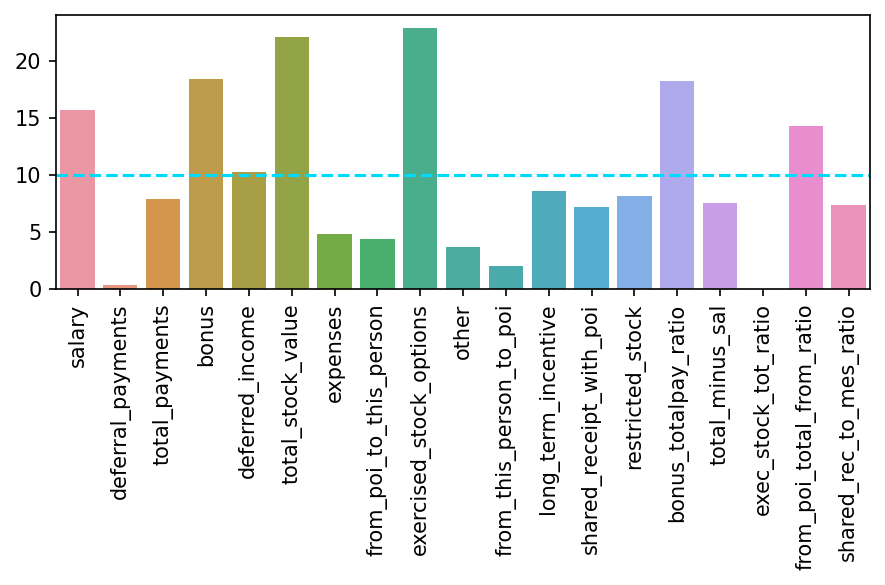

In [36]:
# f_classif kbest

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=7)
selector.fit(features, labels)

scores_data = selector.scores_
scores_df = pd.DataFrame(data = scores_data, index = features_list[1:], columns = ['scores'])
scores_df = scores_df.sort_values(by = 'scores', ascending = False)
print(scores_df)

data = {'scores': selector.scores_, 'features':features_list[1:]}

plt.figure(figsize = (6, 4), dpi = 150)

sns.barplot(x = data['features'], y = data['scores'])
plt.axhline(10, color = '#00daff', linestyle = '--');
plt.xticks(rotation = 90);

Using kbest with with f_classif and selecting the best 7 gives the following features.

In [37]:
features_sel_list = ['poi']
features_sel_list.extend(list(scores_df.index[:7]))
pprint(features_sel_list)

['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'bonus_totalpay_ratio',
 'salary',
 'from_poi_total_from_ratio',
 'deferred_income']


A reduced set of these features will be used to test classifiers for any dependencies.

## Try a varity of classifiers(Task 4)

Based on sklearns [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) and the classification task. I chose to test the following classifiers:
- LogisticRegression
- GuassianNB
- LinearSVC
- KNeighborsClassifier
- RandomForestClassifier
- GradientBoostingClassifier

The classifiers are run using a for loop, with minimal settings applied using Stratified Shuffle Splits (50 splits). This was due to the unbalanced target values which consisted of only 18 positives and 116 negatives. Due to the variation in magnitudes in features and some classifier requirements, all tests use the StandardScalar before fitting. 

The tests below are run with and without scaling. Scaling was shown to benefit LinearSVC and LogisticRegression the most. Those that did not benefit from scaling showed similar results as without scaling so scaling will be used in the final pipeline. 

To verify the selected features lists found in the KBest processing above do give better results, the full feature list and a reduced best features list is also run. Validation and scoring were done using cross validation scoring. The scoring data collected are accuracy, precision, recall and f1 scores. These are collected in a dictionary and displayed as a dataframe following the tests. 

### Performance Metrics for Validation
The performance metrics used to measure a model's performance will be Precision, Recall and the F1 score. These are based on the counts of True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN) values.

In terms of the Enron Fraud data set,
- A true positive occurs when a person is **predicted** by the model to be a person of interest and the person **is** a person of interest ("Got caught").
- A false positive occurs when a person is **predicted** by the model to be a person of interest and the person **is not** a person of interest ("Falsely accussed").
- A True Negative occurs when a person is **predicted** by the model to **not** be a person of interest and the person **is not** a person of interest ("Innocent and not suspected").
- A False Negative occurs when a person is **predicted** by the model to **not** be a person of interest but **is** a person of interest ("Not suspected but guilty" or "Got away with it").

Precision gives the percentage (ratio) of true positives ("Got caught") out of all positive predictions. A 1 would be perfect score (everyone who was guilty got caught) and a zero would be worst possible score (everyone accussed was innocent and no guilty people got caught). 

$$ Precision=\frac{TP}{TP+FP} $$

<br>
Recall gives the percentage (ratio) of true positives ("Got Caught") to the total number of actual positives in the dataset ("Got caught" and "Got away with it").

$$ Recall=\frac{TP}{TP+FN} $$
<br>

The F1 score, also known as the harmonic mean of precision and recall, has a penalizing affect for unbalanced (unequal) precision and recall scores. This penalty is accomplished by multiplying the recall and precision scores together in the numerator so that the lower score "weights" the higher score pulling the score lower.

As an example of the affect of the penalty:

If precision is 0.80 but recall is 0.5 then recall reduces the precision score by 50%

$$ {0.8}\times{0.5} = 0.4 $$

The whole formula for F1 based on the precision and recall scores is:

$$ F1=\frac{2({precision}\times{recall})}{precision+recall} $$

So the above example gives:

$$ F1=\frac{2({0.8}\times{0.5})}{0.8+0.5}=\frac{2(0.4)}{1.3} = \frac{0.8}{1.3}\approx 0.6154 $$

<br>
<br>
The F1 score is lower than the original precision score and slightly higher than the original recall score.


### Metrics and Goals for the Models
The models tested will be evaluated based on the F1 scores and then trying to optimize recall and precision so that both scores are the highest of any other model. This will give the model with the highest F1, Precision and Recall scores.

The reasoning for this choice is the target variable, persons of interest, is unbalanced. Choosing, to maximize precision means the recall score will be lower and more "Guilty but got away with it" people existing. This may lead to unrecovered investor funds and encourageming others to commit fraud in hopes of great gains. Maximizing recall means precision will be lower and more inoccent people will be accused. This could be financially burdensome to investigate innocent people and could lead to lawsuits if anyone is stigmatized publicly by the accusation.

By selecting the F1 score, the model will balance the two scores so that no one score is weighted more than the other score.

In [38]:
# Create dict of scores to compare base models with stratified shuffle split WITHOUT Scaling

# check models using cross_val_score
feature_list_all = features_list
no_scale_clf_results = {}

cv = StratifiedShuffleSplit(n_splits=50, random_state=42)
n_iter = 100

clf_list = [LogisticRegression(max_iter = n_iter),
            GaussianNB(), 
            LinearSVC(max_iter = n_iter * 15), 
            KNeighborsClassifier(n_neighbors = 5), 
            RandomForestClassifier(n_estimators = 30), 
            GradientBoostingClassifier(n_estimators = 150)]

feat_dict ={'all_original_features': feature_list_all, 
            'features_sel_list': features_sel_list, 
            'features_sel_list_k4': features_sel_list[:5]}

for clf_type in clf_list:
    for name in feat_dict:
#         print('*** Start :', clf_type, 'for', name, '\n')
        data = featureFormat(my_dataset, feat_dict[name], sort_keys = True)
        labels, features = targetFeatureSplit(data)
        
#         scaler = StandardScaler()
#         features = scaler.fit_transform(features)

        clf = clf_type
        
        a_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'accuracy', verbose = 0)
        p_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'precision', verbose = 0)
        r_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'recall', verbose = 0)
        f1_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'f1', verbose = 0)
        total_records = len(features)

        means_cvs = [round(a_cvs.mean(), 2),
                     round(p_cvs.mean(), 2),
                     round(r_cvs.mean(),2),
                     round(f1_cvs.mean(),2)]
        
        dict_key = str(clf_type) + '_' + str(name) + '_no_scale'
        no_scale_clf_results[dict_key] = {'accuracy': means_cvs[0],
                                       'precision': means_cvs[1],
                                       'recall': means_cvs[2],
                                       'f1': means_cvs[3],
                                       'total_record': total_records,
                                       'features_count': len(feat_dict[name]) - 1,
                                       'features': feat_dict[name]}
        
#         print('\naccuracy\t', a_cvs)
#         print('precision\t', p_cvs)
#         print('recall\t\t', r_cvs)
#         print('f1\t\t', f1_cvs, '\n')
#         print(means_cvs)

#     print('*** End of :', clf_type, '\n\n')

In [39]:
no_scale_clf_results_df = pd.DataFrame(no_scale_clf_results).transpose()
print('Base classifier results without scaling sorted by classifier.')
no_scale_clf_results_df.sort_index()

Base classifier results without scaling sorted by classifier.


,accuracy,precision,recall,f1,total_record,features_count,features
GaussianNB()_all_original_features_no_scale,0.84,0.31,0.27,0.27,134,19,"[poi, salary, deferral_payments, total_payment..."
GaussianNB()_features_sel_list_k4_no_scale,0.83,0.36,0.26,0.29,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_no_scale,0.85,0.36,0.33,0.32,131,7,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_all_original_features_no_scale,0.84,0.32,0.2,0.23,134,19,"[poi, salary, deferral_payments, total_payment..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k4_no_scale,0.81,0.33,0.27,0.27,121,4,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_no_scale,0.82,0.31,0.29,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
KNeighborsClassifier()_all_original_features_no_scale,0.87,0.28,0.18,0.21,134,19,"[poi, salary, deferral_payments, total_payment..."
KNeighborsClassifier()_features_sel_list_k4_no_scale,0.85,0.29,0.18,0.22,121,4,"[poi, exercised_stock_options, total_stock_val..."
KNeighborsClassifier()_features_sel_list_no_scale,0.87,0.37,0.25,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
LinearSVC(max_iter=1500)_all_original_features_no_scale,0.68,0.12,0.23,0.16,134,19,"[poi, salary, deferral_payments, total_payment..."


In [40]:
# Create dict of scores to compare base models with stratified shuffle split and Standard scaler

# check models using cross_val_score

scale_clf_results = {}

cv = StratifiedShuffleSplit(n_splits=50, random_state=42)
n_iter = 100

clf_list = [LogisticRegression(max_iter = n_iter),
            GaussianNB(), 
            LinearSVC(max_iter = n_iter * 15), 
            KNeighborsClassifier(n_neighbors = 5), 
            RandomForestClassifier(n_estimators = 30), 
            GradientBoostingClassifier(n_estimators = 150)]

feat_dict ={'all_original_features': feature_list_all, 
            'features_sel_list': features_sel_list,
            'features_sel_list_k3': features_sel_list[:4],
            'features_sel_list_k4': features_sel_list[:5]}

for clf_type in clf_list:
    for name in feat_dict:
#         print('*** Start :', clf_type, 'for', name, '\n')
        data = featureFormat(my_dataset, feat_dict[name], sort_keys = True)
        labels, features = targetFeatureSplit(data)
        
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        clf = clf_type
        
        a_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'accuracy', verbose = 0)
        p_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'precision', verbose = 0)
        r_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'recall', verbose = 0)
        f1_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'f1', verbose = 0)
        total_records = len(features)

        means_cvs = [round(a_cvs.mean(), 2),
                     round(p_cvs.mean(), 2),
                     round(r_cvs.mean(),2),
                     round(f1_cvs.mean(),2)]
        
        dict_key = str(clf_type) + '_' + str(name) + '_scaled'
        scale_clf_results[dict_key] = {'accuracy': means_cvs[0],
                                       'precision': means_cvs[1],
                                       'recall': means_cvs[2],
                                       'f1': means_cvs[3],
                                       'total_record': total_records,
                                       'features_count': len(feat_dict[name]) - 1,
                                       'features': feat_dict[name]}
        
#         print('\naccuracy\t', a_cvs)
#         print('precision\t', p_cvs)
#         print('recall\t\t', r_cvs)
#         print('f1\t\t', f1_cvs, '\n')
#         print(means_cvs)

#     print('*** End of :', clf_type, '\n\n')

In [41]:
# Compares scores based on classifier, features and scaling (ordered by classifier)
scale_clf_results_df = pd.DataFrame(scale_clf_results).transpose()

print('Base classifier results with scaling sorted by classifier.')
scale_clf_results_df.sort_index()


Base classifier results with scaling sorted by classifier.


,accuracy,precision,recall,f1,total_record,features_count,features
GaussianNB()_all_original_features_scaled,0.82,0.28,0.27,0.26,134,19,"[poi, salary, deferral_payments, total_payment..."
GaussianNB()_features_sel_list_k3_scaled,0.83,0.36,0.26,0.29,121,3,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k4_scaled,0.85,0.4,0.33,0.34,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_scaled,0.85,0.32,0.29,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_all_original_features_scaled,0.84,0.28,0.18,0.2,134,19,"[poi, salary, deferral_payments, total_payment..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3_scaled,0.8,0.31,0.31,0.3,121,3,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k4_scaled,0.82,0.33,0.28,0.28,121,4,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_scaled,0.82,0.35,0.26,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
KNeighborsClassifier()_all_original_features_scaled,0.84,0.11,0.07,0.08,134,19,"[poi, salary, deferral_payments, total_payment..."
KNeighborsClassifier()_features_sel_list_k3_scaled,0.88,0.53,0.34,0.4,121,3,"[poi, exercised_stock_options, total_stock_val..."


In [42]:
scale_vs_noscale_df = scale_clf_results_df.append(no_scale_clf_results_df).sort_values(by='f1', ascending=False)

In [43]:
# Compare scale versus no scale for classifiers (sorted by classifier)
print('Base classifier results sorted by classifier.')
scale_vs_noscale_df.sort_index()

Base classifier results sorted by classifier.


,accuracy,precision,recall,f1,total_record,features_count,features
GaussianNB()_all_original_features_no_scale,0.84,0.31,0.27,0.27,134,19,"[poi, salary, deferral_payments, total_payment..."
GaussianNB()_all_original_features_scaled,0.82,0.28,0.27,0.26,134,19,"[poi, salary, deferral_payments, total_payment..."
GaussianNB()_features_sel_list_k3_scaled,0.83,0.36,0.26,0.29,121,3,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k4_no_scale,0.83,0.36,0.26,0.29,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k4_scaled,0.85,0.4,0.33,0.34,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_no_scale,0.85,0.36,0.33,0.32,131,7,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_scaled,0.85,0.32,0.29,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_all_original_features_no_scale,0.84,0.32,0.2,0.23,134,19,"[poi, salary, deferral_payments, total_payment..."
GradientBoostingClassifier(n_estimators=150)_all_original_features_scaled,0.84,0.28,0.18,0.2,134,19,"[poi, salary, deferral_payments, total_payment..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3_scaled,0.8,0.31,0.31,0.3,121,3,"[poi, exercised_stock_options, total_stock_val..."


### Scaling affect on scores
LinearSVC and LogisticRegression benifitted from scaling. KNeighborsClassifier shows better performance when there was no scaling but is a distance based classifier. Thus, scaling is required for reliable results. The remainder of the classifiers all seem to remain around the same f1 score with or without scaling. 

In [44]:
# Find best classifiers (ordered by f1 score)
print('Base classifier results sorted by f1 score.')
base_scores_scaled_df = scale_clf_results_df.sort_values(by=['f1', 'recall', 'precision'], ascending = False)
base_scores_scaled_df.head(31)


Base classifier results sorted by f1 score.


,accuracy,precision,recall,f1,total_record,features_count,features
KNeighborsClassifier()_features_sel_list_k3_scaled,0.88,0.53,0.34,0.4,121,3,"[poi, exercised_stock_options, total_stock_val..."
RandomForestClassifier(n_estimators=30)_features_sel_list_k3_scaled,0.86,0.39,0.3,0.35,121,3,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k4_scaled,0.85,0.4,0.33,0.34,121,4,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3_scaled,0.8,0.31,0.31,0.3,121,3,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_scaled,0.85,0.32,0.29,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k3_scaled,0.83,0.36,0.26,0.29,121,3,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_scaled,0.82,0.35,0.26,0.29,131,7,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k4_scaled,0.82,0.33,0.28,0.28,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_all_original_features_scaled,0.82,0.28,0.27,0.26,134,19,"[poi, salary, deferral_payments, total_payment..."
RandomForestClassifier(n_estimators=30)_features_sel_list_k4_scaled,0.85,0.33,0.22,0.26,121,4,"[poi, exercised_stock_options, total_stock_val..."


The KNeighborsClassifier, GuassianNB, RandomForestClassifier and GradientBoostingClassifier showed the best f1 score results with all showing similar recall scores. LinearSVC, LogisticRegression and NeighborsClassifier had instances where the precision or recall rates were below 10% causing the f1 score to be low too. 

Some classifiers failed initially due to convergence issues so the max_iterations were changed and the scaler was changed to MaxMinScaler. Though it did increase the scores in the failing classifiers it did boost the scores enough to match the GaussianNB and GradientBoostingClassifier. Next, the top four classifiers will be tested against the 7 feature list using reduced features to determine if one scores better with a reduced feature list. 

In [45]:
# Checking top estimators using higher splits and smaller set of features

# check models using cross_val_score

featnum_scale_clf_results = {}

cv = StratifiedShuffleSplit(n_splits=100, random_state=42)
n_iter = 150

clf_list = [GaussianNB(),
            RandomForestClassifier(n_estimators=30),
            GradientBoostingClassifier(n_estimators = n_iter),
            KNeighborsClassifier(n_neighbors = 5)]

# Reduced features for testing
feat_dict ={
            'all_original_features': feature_list_all,
            'features_sel_list_k2': features_sel_list[:3], 
            'features_sel_list_k3': features_sel_list[:4],
            'features_sel_list_k4': features_sel_list[:5],
            'features_sel_list_k5': features_sel_list[:6],
            'features_sel_list_k6': features_sel_list[:7],
            'features_sel_list_k7_all': features_sel_list}

for clf_type in clf_list:
    for name in feat_dict:
#         print('*** Start :', clf_type, 'for', name, '\n')
        data = featureFormat(my_dataset, feat_dict[name], sort_keys = True)
        labels, features = targetFeatureSplit(data)
        

        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        clf = clf_type

        a_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'accuracy')
        p_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'precision')
        r_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'recall')
        f1_cvs = cross_val_score(clf, features, labels, cv = cv, scoring = 'f1')
        total_records = len(features)

        means_cvs = [round(a_cvs.mean(), 2),
                     round(p_cvs.mean(), 2),
                     round(r_cvs.mean(), 2),
                     round(f1_cvs.mean(), 2)]

        dict_key = str(clf_type) + '_' + str(name)
        featnum_scale_clf_results[dict_key] = {'accuracy': means_cvs[0],
                                               'precision': means_cvs[1],
                                               'recall': means_cvs[2],
                                               'f1': means_cvs[3],
                                               'total_record': total_records,
                                               'features_count': len(feat_dict[name]) - 1,
                                               'features': feat_dict[name]}

#         print('\naccuracy\t', a_cvs)
#         print('precision\t', p_cvs)
#         print('recall\t\t', r_cvs)
#         print('f1\t\t', f1_cvs, '\n')
#         print(means_cvs)

#     print('*** End of :', clf_type, '\n\n')

In [54]:
featnum_scale_clf_results_df = pd.DataFrame(featnum_scale_clf_results).transpose()
best_clf_df = featnum_scale_clf_results_df.sort_values(by=['f1', 'recall', 'precision'], ascending=False)
best_clf_df


,accuracy,precision,recall,f1,total_record,features_count,features
KNeighborsClassifier()_features_sel_list_k3,0.89,0.55,0.36,0.43,121,3,"[poi, exercised_stock_options, total_stock_val..."
RandomForestClassifier(n_estimators=30)_features_sel_list_k3,0.86,0.51,0.37,0.39,121,3,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k6,0.85,0.47,0.37,0.39,123,6,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k4,0.86,0.45,0.36,0.38,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k3,0.85,0.47,0.34,0.37,121,3,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3,0.81,0.35,0.36,0.35,121,3,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k4,0.82,0.4,0.34,0.35,121,4,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k5,0.84,0.39,0.34,0.34,122,5,"[poi, exercised_stock_options, total_stock_val..."
GradientBoostingClassifier(n_estimators=150)_features_sel_list_k5,0.81,0.37,0.32,0.33,122,5,"[poi, exercised_stock_options, total_stock_val..."
GaussianNB()_features_sel_list_k7_all,0.84,0.36,0.32,0.32,131,7,"[poi, exercised_stock_options, total_stock_val..."


The KNeighborsClassifier shows best f1 score using the top 3 features. The RandomForestClassifier, GaussianNB and GradienBoostingClassifier shows similar f1 scores using 3, 4, 5 and 6 features. I will use 3 features for tuning the KNeighborsClassifier and RandomForestClassifier. The top 4 features for the GradientBoosting tuning. I will also do what little tuning available to the GaussianNB with the top 6 features to see if its scores can be increased. The focus will be on increasing recall scores within the best f1 score categories.


## Task 5: Tune your classifier to achieve better than .3 precision and recall

In [47]:
# Grid search cv GaussianNB()

# Base conditions:
# RandomForestClassifier(n_estimators=30)_features_sel_list_k3	0.86	0.46	0.32	0.40	121.0
# GaussianNB()_features_sel_list_k6	0.85	0.47	0.37	0.39	123.0
# GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3	0.84	0.4 	0.34	0.34	121.0
# KNeighborsClassifier()_features_sel_list_k3	0.89	0.55	0.36	0.43	121

n_splits = 1 # 100

features_list = features_sel_list[0:7]
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)

print('\nFeatures used are:\n', features_list, '\n')

# separate the data into features and target (featureFormat converts "NaN" to zeros and has option to drop rows)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

gnb_clf = Pipeline([('scaler',StandardScaler()), ('gnb', GaussianNB())])
param_grid = {'gnb__var_smoothing': [0.015199110829529336]}   # 0.015199110829529336 from np.logspace(0,-9, num=100)

gnb_grid_model = GridSearchCV(estimator = gnb_clf,
                          param_grid = param_grid,
                          scoring = 'recall',
                          cv = cv,
                          verbose = 1)

gnb_grid_model.fit(features, labels)

gnb_labels_predict = gnb_grid_model.predict(features)

# Final best model for GNB with kbest manual tested (for loop)
# Create empty df to hold classifiers with scores
clf_tuning_scores_df = pd.DataFrame() 

clf = gnb_grid_model.best_estimator_
clf_scores_dict= tester.test_classifier(clf, my_dataset, features_list)
clf_tuning_scores_df = pd.DataFrame.from_dict(clf_scores_dict, orient = 'index').transpose()


Features used are:
 ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'bonus_totalpay_ratio', 'salary', 'from_poi_total_from_ratio'] 

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=0.015199110829529336))])
	Accuracy: 0.85223	Precision: 0.53064	Recall: 0.34200	F1: 0.41593	F2: 0.36818
	Total predictions: 13000	True positives:  684	False positives:  605	False negatives: 1316	True negatives: 10395



In [48]:
# Grid search cv Gradient Boost Classifier

# Base conditions:
# RandomForestClassifier(n_estimators=30)_features_sel_list_k3	0.86	0.46	0.32	0.40	121.0
# GaussianNB()_features_sel_list_k6	0.85	0.47	0.37	0.39	123.0
# GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3	0.84	0.4 	0.34	0.34	121.0
# KNeighborsClassifier()_features_sel_list_k3	0.89	0.55	0.36	0.43	121

n_splits = 1 # 100

features_list = features_sel_list[0:5]
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)

print('\nFeatures used are:\n', features_list, '\n')

# separate the data into features and target (featureFormat converts "NaN" to zeros and has option to drop rows)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

gbc_clf = Pipeline([('scaler',StandardScaler()), 
                    ('gbc', GradientBoostingClassifier())])

param_grid = {
              'gbc__max_depth': [9],              # [3, 4, 5, 6, 7, 8, 9, 10]  -> 9
              'gbc__learning_rate': [0.04],       # [0.01, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.08, .1]  -> 0.04
              'gbc__min_samples_split': [15],     # [2, 5, 10, 12, 13, 14 15, 16, 20, 40, 60]  -> 15
              'gbc__n_estimators': [154]          # [120, 130, 140, 150, 154, 155, 156, 160, 170, 180]  -> 154
             }

gbc_grid_model = GridSearchCV(estimator = gbc_clf,
                          param_grid = param_grid,
                          scoring = 'f1',
                          cv = cv,
                          verbose = 1)

gbc_grid_model.fit(features, labels)
gbc_labels_predict = gbc_grid_model.predict(features)

# # Final model for gbc
clf = gbc_grid_model.best_estimator_
clf_scores_dict = tester.test_classifier(clf, my_dataset, features_list)
clf_tuning_scores_df = clf_tuning_scores_df.append(clf_scores_dict, ignore_index = True)


Features used are:
 ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'bonus_totalpay_ratio'] 

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.04, max_depth=9,
                                            min_samples_split=15,
                                            n_estimators=154))])
	Accuracy: 0.83223	Precision: 0.44597	Recall: 0.37350	F1: 0.40653	F2: 0.38605
	Total predictions: 13000	True positives:  747	False positives:  928	False negatives: 1253	True negatives: 10072



In [49]:
# Grid search cv RandomForestClassifier

# Base conditions:
# RandomForestClassifier(n_estimators=30)_features_sel_list_k3	0.86	0.46	0.32	0.40	121.0
# GaussianNB()_features_sel_list_k6	0.85	0.47	0.37	0.39	123.0
# GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3	0.84	0.4 	0.34	0.34	121.0
# KNeighborsClassifier()_features_sel_list_k3	0.89	0.55	0.36	0.43	121

n_splits = 1 # 100

features_list = features_sel_list[0:4]
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)

print('\nFeatures used are:\n', features_list, '\n')

# separate the data into features and target (featureFormat converts "NaN" to zeros and has option to drop rows)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

rfc_clf = Pipeline([('scaler',StandardScaler()), 
                    ('rfc', RandomForestClassifier())])

param_grid = {
              'rfc__criterion': ['gini'],                 # [['gini', 'entropy'] -> gini
              'rfc__max_features': [None],                # [None, 'auto', 'log2'] -> None
              'rfc__max_depth': [100],                    # [4, 7, 9, 11, 25, 50, 90, 100, 110, 130]  -> 100
              'rfc__min_samples_split': [3],              # [2, 3, 4, 6, 8, 10] -> 3
              'rfc__n_estimators': [30]                   # [5, 10, 20, 25, 30, 35, 40, 50, 150, 250, 500] -> 30
             }

rfc_grid_model = GridSearchCV(estimator = rfc_clf,
                          param_grid = param_grid,
                          scoring = 'f1',
                          cv = cv,
                          verbose = 1)

rfc_grid_model.fit(features, labels)
rfc_labels_predict = rfc_grid_model.predict(features)

# # Final model for gbc
clf = rfc_grid_model.best_estimator_
clf_scores_dict = tester.test_classifier(clf, my_dataset, features_list)
clf_tuning_scores_df = clf_tuning_scores_df.append(clf_scores_dict, ignore_index = True)


Features used are:
 ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus'] 

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=100, max_features=None,
                                        min_samples_split=3,
                                        n_estimators=30))])
	Accuracy: 0.83969	Precision: 0.47417	Recall: 0.38550	F1: 0.42526	F2: 0.40048
	Total predictions: 13000	True positives:  771	False positives:  855	False negatives: 1229	True negatives: 10145



In [50]:
# Grid search cv KNeighborsClassifier

# Base conditions:
# RandomForestClassifier(n_estimators=30)_features_sel_list_k3	0.86	0.46	0.32	0.40	121.0
# GaussianNB()_features_sel_list_k6	0.85	0.47	0.37	0.39	123.0
# GradientBoostingClassifier(n_estimators=150)_features_sel_list_k3	0.84	0.4 	0.34	0.34	121.0
# KNeighborsClassifier()_features_sel_list_k3	0.89	0.55	0.36	0.43	121

n_splits = 1 # 100

features_list = features_sel_list[0:4]
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)

print('\nFeatures used are:\n', features_list, '\n')

# separate the data into features and target (featureFormat converts "NaN" to zeros and has option to drop rows)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

knnc_clf = Pipeline([('scaler',StandardScaler()), 
                    ('knnc', KNeighborsClassifier())])

param_grid = {
              'knnc__metric': ['minkowski'],                 # ['minkowski', 'chebyshev']  --> 'minkowski'
              'knnc__p': [1] ,                                # [1, 2, 3]  --> 1
              'knnc__n_neighbors': [4],                      # np.arange(1, 12, 1)  --> 4
              'knnc__weights': ['distance'],                 # ['uniform', 'distance']  --> 'distance'
              'knnc__leaf_size': [2]                        # np.arange(2, 15, 1)  --> 2
             }

knnc_grid_model = GridSearchCV(estimator = knnc_clf,
                              param_grid = param_grid,
                              scoring = 'f1',
                              cv = cv,
                              verbose = 1)

knnc_grid_model.fit(features, labels)
knnc_labels_predict = knnc_grid_model.predict(features)

# # Final model for gbc
long_run_time = False
if long_run_time:
    for folds in [1000, 10000, 100000]:
        clf = knnc_grid_model.best_estimator_
        clf_scores_dict = tester.test_classifier(clf, my_dataset, features_list, folds = folds)  # 10000, 100000
        clf_tuning_scores_df = clf_tuning_scores_df.append(clf_scores_dict, ignore_index = True)
else:
    clf = knnc_grid_model.best_estimator_
    clf_scores_dict = tester.test_classifier(clf, my_dataset, features_list)
    clf_tuning_scores_df = clf_tuning_scores_df.append(clf_scores_dict, ignore_index = True)


Features used are:
 ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus'] 

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('knnc',
                 KNeighborsClassifier(leaf_size=2, n_neighbors=4, p=1,
                                      weights='distance'))])
	Accuracy: 0.87285	Precision: 0.63981	Recall: 0.39700	F1: 0.48997	F2: 0.42961
	Total predictions: 13000	True positives:  794	False positives:  447	False negatives: 1206	True negatives: 10553



In [51]:
clf_tuning_scores_df.sort_values(by = ['f1', 'recall', 'precision'], ascending = False, inplace = True)
clf_scores_list = ['classifier', 'total_predictions', 'accuracy', 'precision', 'recall', 'f1', 'f2']

clf_tuning_scores_df[clf_scores_list]

,classifier,total_predictions,accuracy,precision,recall,f1,f2
3,KNeighborsClassifier,13000,0.872846,0.639807,0.397,0.489972,0.429607
2,RandomForestClassifier,13000,0.839692,0.47417,0.3855,0.425262,0.400478
0,GaussianNB,13000,0.852231,0.530644,0.342,0.415932,0.368177
1,GradientBoostingClassifier,13000,0.832231,0.44597,0.3735,0.406531,0.386047


In [52]:
#### below discuss why you picked rfc over gaus 
# (recall was slightly higer in picking poi at cost of precision) Best Harmonic score (balanced)

|**Classifier**|**Total Predictions**|**Accuracy**|**Precision**|**Recall**|**F1**|**F2**|
|:-- | :-: | :-: | :-: | :-: | :-: | :-: |
|KNeighborsClassifier|13,000|0.87|0.63|0.39|0.48|0.42|
|RandomForestClassifier|13,000|0.84|0.448|0.39|0.43|0.40|
|GaussianNB|13,000|0.85|0.53|0.34|0.41|0.36|
|GradientBoostingClassifier|13,000|0.83|0.44|0.37|0.40|0.38|
|GaussianNB|13,000|0.85|0.53|0.34|0.41|0.36|
|**KNeighborsClassifier** |**130,000**|0.871|0.628|0.392|0.483|0.424|
|**KNeighborsClassifier** |**1,300,000**|0.872|0.637|0.397|0.489|0.430|



Based on the F1 scores KNeighborsClassifier is the best model with the following parameters:

KNeighborsClassifier(leaf_size=2, n_neighbors=4, p=1, weights='distance')

This gave the following scores when run on 1,300,000 samples:

	Accuracy: 0.87	 Precision: 0.63 	Recall: 0.39 	    F1: 0.48 	    F2: 0.43 

The smaller runs of 13,000 and 130,000 gave the same result to two decimal places.

This model is expected to have an accuracy of 87%. The precision is expected to be 63% meaning 63% of those identified as being persons of interst will be persons of interest. This also means that 37% of those identified of being person of interest are actually not persons of interest. The recall is expected to be 39% meaning 39% of the persons of interest will be identified leaving 61% of the persons of interest unidentified or missed.

This ratio was chosen over the others as it had the highest F1 and precision values while still obtaining the highest recall rate. This balance was chosen to reduce investigation costs of innocent people and minimize possible law suits of those falsely accused while still mathcing the highest recall score of all the models. This recall rate matches or surpasses the other model's recall rates and will help identify over a third of all true persons of interest among all the true persons of interest.

## Conclusion
The goal of this project iwas to use Machine Learning algorithms from the sklearn library to detect persons of interest related to the Enron accounting fraud and eventual colapse of Enron Corporation.

After exploratory data analysis the following people or entities were removed due to being outliers or containing too few selected features:
- LOCKHART EUGENE E
- SCRIMSHAW MATTHEW
- WHALEY DAVID A
- CLINE KENNETH W
- CHAN RONNIE
- WROBEL BRUCE
- LOWRY CHARLES P
- CHRISTODOULOU DIOMEDES
- GATHMANN WILLIAM D
- GILLIS JOHN
- THE TRAVEL AGENCY IN THE PARK
- TOTAL

The features were analyed using pair plots and correlation matrices to find the most relevant features and to attempt to reduce the number of features. The following new features were added:

- bonus_totalpay_ratio
- total_minus_sal
- exec_stock_tot_ratio
- from_poi_total_from_ratio
- shared_rec_to_mes_ratio

The top 7 features were selected using SelectKBest and are listed below:

1.  exercised_stock_options
2.  total_stock_value
3.  bonus
4.  bonus_totalpay_ratio
5.  salary
6.  from_poi_total_from_ratio
7.  deferred_income

The 7 features above were tested on the following classifiers based on sklearns [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to find determine the best base estimator:

- LogisticRegression
- GuassianNB
- LinearSVC
- KNeighborsClassifier
- RandomForestClassifier
- GradientBoostingClassifier

It was found that GaussianNB, KNeighborsClassifier, RandomForestClassifier and GradientBoostingClassifier gave similar F1 and recall scores based on a modified feature selection list. Therefore, it was decided to hypertune all 4 classifiers basded on the best feature list for the model and determine which best met the goal of maximizing F1 scores and precision verus recall trade-offs.

It was found that KNeighborsClassifier was the best model with the following parameters:

KNeighborsClassifier(leaf_size=2, n_neighbors=4, p=1, weights='distance')

This gave the following scores when run on 1,300,000 samples:

	Accuracy: 0.87244	Precision: 0.63699	Recall: 0.39719	F1: 0.48929	F2: 0.42953

Smaller runs of 13,000 and 130,000 were run and gave the same result to two decimal places.

The model is expected to have an accuracy of 87%. The precision is expected to be 63% meaning 63% of those identified as being persons of interst will be persons of interest. This also means that 37% of those identified of being person of interest are actually not persons of interest. The recall is expected to be 39% meaning 39% of the persons of interest will be identified leaving 61% of the persons of interest unidentified or missed.

This ratio was chosen as it had the highest precision value while still obtaining the highest recall rate. This balance was chosen to reduce investigation costs of innocent people and minimize possible law suits of those falsely accused.


### Areas of Imporvement and Future Study
Though the project met the goals and specifications, there are areas that could possibly improve target identification. Three are given below.

- More features could be used to create new features (feature engineering) and analyzed to see if another combination leads to better identification of persons of interest. There seems there would be a hidden relationship that could identify differences in persons of interest versus non-persons of interest with a higher probability.

- The dataset could be further researched, cleaned and analyzed. Though I do know some of the facts about the Enron collapse, I am by no means knowledgeble of all aspects. Conducting research to get missing data for individuals would likely help the models tested. In addition, researching which persons were likely involved but not prosecuted due to providing evidence, being a witness or lack of "substantial" evidence might identify persons of interest mis-labeled as false.

- Hypertune other models. Some models showed mediocre results when run with default parameters and therefore were not chosen. These models, with correctly tuned parameters might outperform the KNeighborsClassifier. This would take more time and processing power but could be accomplished using off-peak hour runs.

The project did exceed the goals of .30 minimum recall and precision.  In addition, hypertuning was conducted on 4 classifiers leading to the choosing the best of the 4 models. It allowed comparison of different models and how much a change in parameter affected one model versus another.


## Task 6: Dump your classifier, dataset, and `features_list` so anyone can

Check your results. You do not need to change anything below, but make sure
that the version of `poi_id.py` that you submit can be run on its own and
generates the necessary `.pkl` files for validating your results.

In [53]:
import tester
dump_classifier_and_data(clf, my_dataset, features_list)